In [1]:
using HDF5
using Plots

In [23]:
n_snap = 100
snapshots = collect(0:n_snap-1)
file_dir = "/home/rmcg/data/downloaded/tng/tng100-3-dark/merger_tree/lhalotree/"

file_name = readdir(file_dir)[1]
hdf5_file = h5open(file_dir*file_name, "r")
n_halo = read(hdf5_file, "Header/TotNsubhalos")[n_snap]

i_history = 1
arr_mass_history = zeros(Float32, n_halo, n_snap)

for file_name in readdir(file_dir)
    hdf5_file = h5open(file_dir*file_name, "r")
    for tree_name in filter(contains("Tree"), keys(hdf5_file))
        arr_snap_num = read(hdf5_file, tree_name*"/SnapNum")
        arr_subhalo_mass = read(hdf5_file, tree_name*"/SubhaloMassType")
        arr_subhalo_mass = sum(arr_subhalo_mass, dims=1)
        arr_first_prog = read(hdf5_file, tree_name*"/FirstProgenitor")
        arr_first_prog .+= 1  # Julia uses 1-based indexing
        
        for i_halo in 1:size(arr_snap_num, 1)
            snap_num = arr_snap_num[i_halo]
            if snap_num != n_snap - 1
                continue
            end
            arr_mass_history[i_history, snap_num+1] = arr_subhalo_mass[i_halo]
            i_prog = arr_first_prog[i_halo]
            while i_prog != 0
                snap_num = arr_snap_num[i_prog]
                arr_mass_history[i_history, snap_num+1] = arr_subhalo_mass[i_prog]
                i_prog = arr_first_prog[i_prog]
            end
            i_history += 1
        end
    end
end

In [24]:
# Remove halos that can't be tracked
@assert size(arr_mass_history, 2) == n_snap
min_snap = 25
mask = arr_mass_history[:, min_snap] .!= 0
arr_mass_history = arr_mass_history[mask, :]
arr_mass_history = arr_mass_history[:, min_snap:end]
snapshots = snapshots[min_snap:end];

In [25]:
# Fill in missing values
mask = arr_mass_history[:, 2:end] .== 0
arr_mass_history[:, 2:end] .+= arr_mass_history[:, 1:end-1] .* mask;

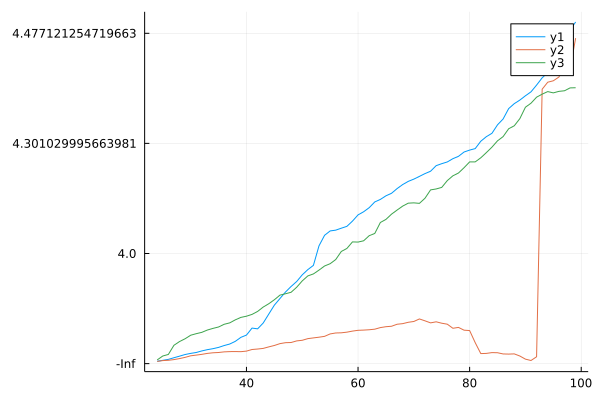

In [30]:
# Sort by final mass
p = sortperm(arr_mass_history[:, end], rev=true)
arr_mass_history = arr_mass_history[p, :]
plot(snapshots, transpose(arr_mass_history[1:3, :]), yaxis=log10)